In [3]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data/tiny_sample_data.csv')

In [3]:
data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User
0,1.498121e+12,-10.223242,-4.031835,-4.865018,-0.390958,0.456892,-0.517477,0.082608,0.579526,0.810031,-0.033991,220617,Hand,2.0,5.0,1,User1
1,1.498121e+12,-9.102754,-1.781286,-8.078036,0.342843,-1.087437,1.090648,0.175092,0.527139,0.828302,-0.073106,220617,Hand,2.0,5.0,1,User1
2,1.498121e+12,-7.067683,-3.792415,-12.239159,1.641834,-3.020055,-3.591452,0.247089,0.381125,0.852983,-0.256846,220617,Hand,2.0,5.0,1,User1
3,1.498121e+12,-8.844416,-0.181914,-11.118354,1.025997,-2.625678,-1.296871,0.430142,0.219153,0.741506,-0.465945,220617,Hand,2.0,5.0,1,User1
4,1.498121e+12,3.179461,0.718264,-9.935942,-3.889429,5.263189,1.311569,0.225644,0.255715,0.823396,-0.453160,220617,Hand,2.0,5.0,1,User1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68836,1.497460e+12,-9.368783,-2.587768,0.192931,-0.129918,0.080427,-0.304560,0.384867,-0.676317,0.228131,0.585172,140617,Torso,2.0,5.0,34,User3
68837,1.497460e+12,-8.193694,-1.666364,0.753842,-0.528795,-0.085802,0.065608,0.367071,-0.672108,0.218054,0.604961,140617,Torso,2.0,5.0,34,User3
68838,1.497460e+12,-9.632220,-1.501508,1.749135,0.109280,-0.347863,0.169926,0.389664,-0.652718,0.251713,0.598966,140617,Torso,2.0,5.0,34,User3
68839,1.497460e+12,-9.561332,-2.722536,-1.511116,-0.507558,0.180567,0.434380,0.329911,-0.694583,0.243898,0.590950,140617,Torso,2.0,5.0,34,User3


In [4]:
data.groupby(['User', 'Position'])['Segment'].count()

User   Position
User1  Bag         6190
       Hand        6191
       Hips        6190
       Torso       6190
User2  Bag         7020
       Hand        7020
       Hips        7020
       Torso       7020
User3  Bag         4000
       Hand        4000
       Hips        4000
       Torso       4000
Name: Segment, dtype: int64

In [5]:
data.query('User == "User1"').groupby('Segment')[['User']].count()

,User
Segment,
1,164
2,104
3,352
4,176
5,1792
6,1144
7,1656
8,1429
9,952


In [6]:
a = data.query('User == "User1"').groupby('Coarse_label')[['Segment']].nunique()
a['Count'] = data.query('User == "User1"').groupby('Coarse_label')['Segment'].count().values
a

,Segment,Count
Coarse_label,,
1.0,7,3444
2.0,9,2777
3.0,1,612
4.0,4,2140
5.0,3,4400
6.0,5,4172
7.0,2,3612
8.0,2,3604


# Preprocessing #1
Let's create more journeys (sub-segments) from each of the main segments using windows. From our reference paper, we're going to sample using a sliding fixed window of 2.56secs and 50% overlap

Data was downsampled to 5Hz i.e. 5 datapoints per second. Therefore our window should cover;
$$2.56~*~5 = 12$$

So the idea is to create new data for each segment for each user. 

-----
UPDATE:\
Instead of going with 2.56secs which results in a meager 12 datapoints, I'll go with 112 datapoints so as to capture more information due to the low sampling rate, 
$$x~*~5 = 112$$
$$x=22.4secs$$


In [1]:
# Define the window size and overlap
#window_size = 12  # 2.56 seconds * 5 Hz = 12 datapoints
window_size = 112  # 22.4 seconds for my 5 Hz = 112 datapoints
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Calculate the step size based on the overlap

# Path to the combined dataset
input_file = './data/tiny_sample_data.csv'
output_file = './data/sample_sub_segmented_data_112.csv'

# Function to create sub-segments using sliding window
def create_sub_segments(data, window_size, step_size):
      sub_segments = []
      for (user, position), user_position_data in data.groupby(['User', 'Position']):
            sub_segment_id = 1
            for segment, segment_data in user_position_data.groupby('Segment'):
                  for start in range(0, len(segment_data) - window_size + 1, step_size):
                        end = start + window_size
                        sub_segment = segment_data.iloc[start:end].copy()
                        sub_segment['Sub_Segment'] = sub_segment_id
                        sub_segments.append(sub_segment)
                        sub_segment_id += 1
      return pd.concat(sub_segments).reset_index(drop=True)

In [4]:
# # Read the entire dataset
data = pd.read_csv(input_file)

# Create sub-segments
sub_segmented_data = create_sub_segments(data, window_size, step_size)

# Save the sub-segmented data
sub_segmented_data.to_csv(output_file, index=False, header=True)

print(f"Sub-segmented data has been saved to '{output_file}'")

Sub-segmented data has been saved to './data/sample_sub_segmented_data_112.csv'


____

In [2]:
import pandas as pd
import numpy as np

In [3]:
subbed_data = pd.read_csv('./data/sample_sub_segmented_data_112.csv')

In [4]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81984 entries, 0 to 81983
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_ms         81984 non-null  float64
 1   acceleration_x  81984 non-null  float64
 2   acceleration_y  81984 non-null  float64
 3   acceleration_z  81984 non-null  float64
 4   gyroscope_x     81984 non-null  float64
 5   gyroscope_y     81984 non-null  float64
 6   gyroscope_z     81984 non-null  float64
 7   orientation_w   81984 non-null  float64
 8   orientation_x   81984 non-null  float64
 9   orientation_y   81984 non-null  float64
 10  orientation_z   81984 non-null  float64
 11  Date            81984 non-null  int64  
 12  Position        81984 non-null  object 
 13  Coarse_label    81984 non-null  float64
 14  Fine_label      81984 non-null  float64
 15  Segment         81984 non-null  int64  
 16  User            81984 non-null  object 
 17  Sub_Segment     81984 non-null 

In [5]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,-0.090730,220617,Bag,5.0,9.0,5,User1,1
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,-0.090835,220617,Bag,5.0,9.0,5,User1,1
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,-0.093983,220617,Bag,5.0,9.0,5,User1,1
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,-0.096611,220617,Bag,5.0,9.0,5,User1,1
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,-0.098922,220617,Bag,5.0,9.0,5,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81979,1.497457e+12,-9.519346,-0.667579,1.855103,-0.016491,-0.055587,-0.010996,0.496516,-0.515839,0.372483,0.590455,140617,Torso,7.0,15.0,33,User3,43
81980,1.497457e+12,-9.628084,-0.666983,1.726616,0.022056,0.010866,-0.030013,0.496643,-0.517091,0.373129,0.588842,140617,Torso,7.0,15.0,33,User3,43
81981,1.497457e+12,-9.560941,-0.734126,1.985687,0.002953,-0.019577,-0.006734,0.497868,-0.515147,0.372450,0.589941,140617,Torso,7.0,15.0,33,User3,43
81982,1.497457e+12,-9.628085,-0.664193,1.838747,0.015256,0.041539,0.015226,0.496358,-0.516541,0.376265,0.587569,140617,Torso,7.0,15.0,33,User3,43


In [6]:
subbed_data.groupby(['User', 'Position', 'Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Position Segment             
User1 Bag      5                784
               6                448
               7                672
               8                560
               9                336
...                             ...
User3 Torso    25               672
               28               448
               29               784
               31               112
               33               560

[200 rows x 1 columns]

In [7]:
# this shows that all the sub-sections are divisible by 112
(subbed_data.groupby(['User', 'Position', 'Segment'])[['Sub_Segment']].count()%112).sum()

Sub_Segment    0
dtype: int64

### Feature Extraction for LSTM
Idea is to go through the dataset and create a feature vector like;

|$a_x$|$a_y$|$a_z$|$w_x$|$w_y$|$w_z$|$Label$|
|--|--|--|--|--|--|--|
|112 vector|112 vector|112 vector|112 vector|112 vector|112 vector|1 vector|

We already achieved the windowing as described in the paper. So what we can do is that for each subsegment, we take the 112 and it's corresponding label and then move over to the next 112.

***EDIT***

This changed from 128 to 112 for ease of sync with the CNN-GRU features

In [8]:
a = np.arange(112*5)

start=0
window = 112
for i in range(0, int(len(a)/window), 1):
      end = start + window
      print(start, end,len(a[start:end]))
      start = end

0 112 112
112 224 112
224 336 112
336 448 112
448 560 112


What I want to do is to initialize a numpy array of the same shape as expected after extracting features from this dataset. Its length should be the length of the dataset divided by 12

In [9]:
start = 0
window = 112

# Create empty arrays for features and labels
num_samples = len(subbed_data) // window
num_features = 6
lstm_features = np.empty((num_samples, window, num_features))
lstm_labels = np.empty(num_samples)

for i in range(num_samples):
      end = start + window
      chunk = subbed_data.iloc[start:end, :]

      # Extract features
      lstm_features[i, :, 0] = chunk['acceleration_x'].values    # acceleration_x
      lstm_features[i, :, 1] = chunk['acceleration_y'].values    # acceleration_y
      lstm_features[i, :, 2] = chunk['acceleration_z'].values    # acceleration_z
      lstm_features[i, :, 3] = chunk['gyroscope_x'].values       # gyroscope_x
      lstm_features[i, :, 4] = chunk['gyroscope_y'].values       # gyroscope_y
      lstm_features[i, :, 5] = chunk['gyroscope_z'].values       # gyroscope_z

      # Extract label (assuming one label per chunk)
      lab_list = np.unique(chunk['Coarse_label'].values)
      if len(lab_list) == 1:
            lstm_labels[i] = lab_list[0]
      else:
            # Handle case where there are multiple labels in a chunk
            lstm_labels[i] = lab_list[0]  # or some other strategy to resolve conflicts

      start = end

In [10]:
np.save('./data/lstm_features_labels/lstm_features_112.npy', lstm_features)
np.save('./data/lstm_features_labels/lstm_labels_112.npy', lstm_labels)

print(lstm_features.shape)  # Should be (num_samples, window, num_features)
print(lstm_labels.shape)    # Should be (num_samples,)

(732, 112, 6)
(732,)


In [11]:
len(lstm_features)

732

In [12]:
del lstm_features, lstm_labels

### Feature Extraction for CNN-RNN
We need to get the longitudinal acceleration, transversal acceleration and angular velocity for this data before we look to apply the 1D to 2D mapping

* What's the idea for this again? Remember that our journeys are the sub-segments

In [12]:
subbed_data.query("Position == 'Bag' & User == 'User1'").groupby('Coarse_label')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
Coarse_label,,
1.0,2,10
2.0,1,5
3.0,1,1
4.0,3,4
5.0,3,16
6.0,3,11
7.0,2,13
8.0,2,13


In [13]:
subbed_data.query("Coarse_label == 5.0").groupby('User')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
User,,
User1,3,16
User2,4,26


In [14]:
subbed_data.query("Coarse_label == 5.0 & Position=='Hand'").groupby(['User','Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Segment             
User1 5                784
      7                672
      9                336
User2 64              1568
      66               224
      70               560
      73               560

In [15]:
a = pd.read_csv('./data/train_data_User3.csv')

In [16]:
a['Coarse_label'].value_counts()

Coarse_label
7.0    246300
1.0    183898
2.0    159313
4.0     51904
Name: count, dtype: int64

In [17]:
del a

It seems like User 3 has no driving data. This looks like it might present a problem. I'll have to download an additional dataset an add to this. For now, ignore this as this User 3 driving won't be predicted. Seeing as the additional data is a mixture of User2 and User3, it can be added in as unsupervised learning if time permits. For now, kindly forge ahead and let Johan know. http://www.shl-dataset.org/activity-recognition-challenge-2020/

Problem can be binary for now i.e. the CNN and RNN part. LSTM doesn't really care if its missing as it doesn't take driver detail into consideration.

To continue with the feature extractor for this CNN-GRU part, we need to get the longitudinal and transversal acceleration from the $acc_x$, $acc_y$, and $acc_z$. To get that, I'll need to get the rotation matrix for every subsection??

* My next question/confusion was related to how journeys are understood for this task. Given that this is a multi-task problem, I would want to retain the fact that the journeys are split this way. I mean, the purpose of research is to try out new things. Failure is also a good result. 
* As a result the plan is to transform the sub-segment journeys to long acc, tranv acc and ang vel and then convert those to 2D. No need for windows seeing as these subjourneys were already windowed. You get?


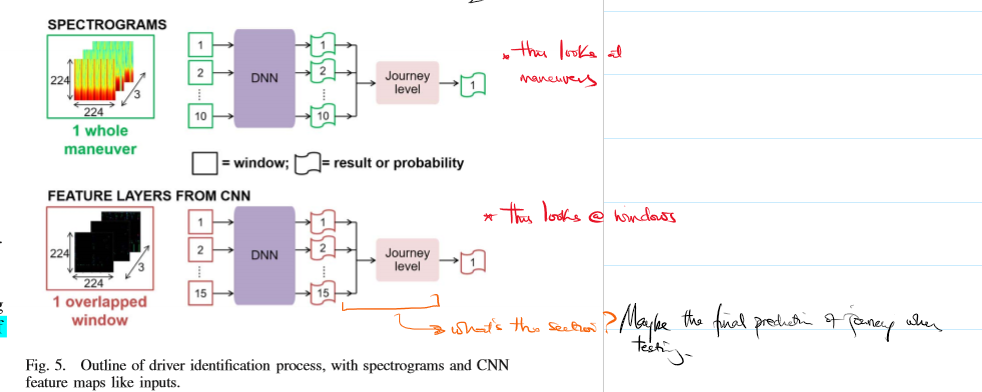

#### Getting the Euler's angles from the Quaternions

$$\varphi=\arctan{\left( \frac{2(q_1q_0+q_2q_3)}{q_0^2-q_1^2-q_2^2+q_3^2} \right)}$$

$$ \theta=-\arcsin(2(q_1q_3-q_2q_0))$$

$$\psi=\arctan{\left( \frac{2(q_3q_0+q_1q_2)}{q_0^2+q_1^2-q_2^2-q_3^2} \right)}$$



In [18]:
def euler_from_quaternions(q):
      '''
      Gets the Euler angles (roll, pitch and yaw) from quaternions using (ZYX notation)
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         roll, pitch, and yaw in degrees
      '''
      q0, q1, q2, q3 = q

      # Roll (x-axis rotation)
      roll = np.arctan2(2 * (q1 * q0 + q2 * q3), q0**2 - q1**2 - q2**2 + q3**2)

      # Pitch (y-axis rotation)
      pitch = -np.arcsin(2 * (q1 * q3 - q2 * q0))

      # Yaw (z-axis rotation)
      yaw = np.arctan2(2 * (q3 * q0 + q1 * q2), q0**2 + q1**2 - q2**2 - q3**2)

      return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)


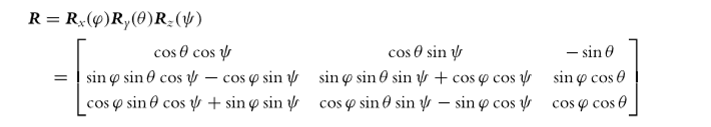

In [19]:
def get_rot_from_euler(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      R = np.array([
                  [(np.cos(pitch)* np.cos(yaw)), (np.cos(pitch) * np.sin(yaw)), -np.sin(pitch)],
                  [((np.sin(roll)*np.sin(pitch)*np.cos(yaw)) - (np.cos(roll)*np.sin(yaw))), ((np.sin(roll)*np.sin(pitch)*np.sin(yaw)) + (np.cos(roll) * np.cos(yaw))), (np.sin(roll) * np.cos(pitch))],
                  [((np.cos(roll)*np.sin(pitch)*np.cos(yaw)) + (np.sin(roll)*np.sin(yaw))), ((np.cos(roll)*np.sin(pitch)*np.sin(yaw)) - (np.sin(roll) * np.cos(yaw))), (np.cos(roll) * np.cos(pitch))]
                  ])

      return R

Let's try out the other method;

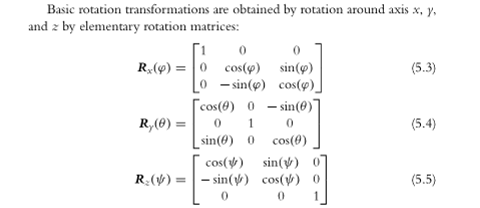

In [20]:
def get_rot_from_euler2(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      Rx = np.array([
                    [1, 0, 0],
                    [0, np.cos(roll), np.sin(roll)],
                    [0, -np.sin(roll), np.cos(roll)]
                    ])
      Ry = np.array([
                    [np.cos(pitch), 0, -np.sin(pitch)],
                    [0, 1, 0],
                    [np.sin(pitch), 1, np.cos(pitch)]
                    ])
      Rz = np.array([
                    [np.cos(yaw), np.sin(yaw), 0],
                    [-np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]
                    ])
      
      R = Rx @ Ry @ Rz

      return R

There's actually no need to convert this to Euler angles instead we can just get the Rotation Matrix (ZYX) from it

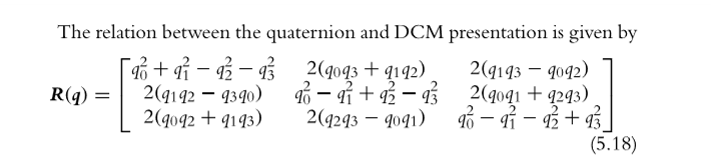

This means, you'll have to take the median of the quartenions for each subsegment and apply the rotation matrix to rotate that.

In [21]:
def quaternion_to_rotation_matrix_zyx(q):
      '''
      Get rotation matrix (ZYX notation) from quaternion
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         rotation matrix (ZYX notation), numpy array
      '''
      q0, q1, q2, q3 = q

      # rotation matrix
      R = np.array([
                  [(q0**2 + q1**2 - q2**2 - q3**2), 2*(q0*q3 + q1*q2), 2*(q1*q3 - q0*q2)],
                  [2*(q1*q2 - q3*q0), (q0**2 - q1**2 + q2**2 - q3**2), 2*(q0*q1 + q2*q3)],
                  [2*(q0*q2 + q1*q3), 2*(q2*q3 - q0*q1), (q0**2 - q1**2 - q2**2 + q3**2)]
                  ])

      return R

def get_rotation_matrix_sub_segment(sub_segment):
      '''
      For each sub_segment or sub_journey, we estimate the median quaternion and use it to create our rotation matrix
      Input:
            sub_segment: Array containing orientation coordinates w, x, y, z for sub_segment. Expected shape
                         is (len(sub_segment), 4)
      Output:
            rotation matrix (ZYX notation). numpy array
      '''
      q = sub_segment.median()

      R = quaternion_to_rotation_matrix_zyx(q)

      return R
      

**You know, for now, we'll have to stick with using the Euler angles to derive our rotation matrix because I don't think getting using the median of the quaternion and the median of the Euler angles will result in the same rotation matrix. As a result, this might cause some problems. For now, we stick with euler angles**

In [22]:
subbed_data.query("User == 'User1' & Position == 'Hand' & Coarse_label==5.0")['Sub_Segment'].unique()

array([ 1,  2,  3,  4,  5,  6,  7, 12, 13, 14, 15, 16, 17, 23, 24, 25],
      dtype=int64)

In [23]:
get_rotation_matrix_sub_segment(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[-0.6657154 ,  0.16747421, -0.27557513],
       [-0.18850761,  0.3107695 ,  0.64424643],
       [ 0.26163743,  0.65003151, -0.23700453]])

In [24]:
get_rot_from_euler(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.20423923,  0.25661889,  0.94468676],
       [ 0.70805593,  0.62765678, -0.32357962],
       [-0.67597569,  0.73497872, -0.05350838]])

In [25]:
get_rot_from_euler2(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.20423923,  0.25661889,  0.94468676],
       [ 1.48000927,  0.01327035, -0.32357962],
       [-0.54832249,  0.63338139, -0.05350838]])

Slightly different values but later on, I'll check to see why

-----------

* For each sub_segment,
   - get the rotation matrix
   - apply to sub_segment and get long acc and transv acc
   - get the magnitude of the gyro measurements --> angular velocity

In [26]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,-0.090730,220617,Bag,5.0,9.0,5,User1,1
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,-0.090835,220617,Bag,5.0,9.0,5,User1,1
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,-0.093983,220617,Bag,5.0,9.0,5,User1,1
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,-0.096611,220617,Bag,5.0,9.0,5,User1,1
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,-0.098922,220617,Bag,5.0,9.0,5,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81979,1.497457e+12,-9.519346,-0.667579,1.855103,-0.016491,-0.055587,-0.010996,0.496516,-0.515839,0.372483,0.590455,140617,Torso,7.0,15.0,33,User3,43
81980,1.497457e+12,-9.628084,-0.666983,1.726616,0.022056,0.010866,-0.030013,0.496643,-0.517091,0.373129,0.588842,140617,Torso,7.0,15.0,33,User3,43
81981,1.497457e+12,-9.560941,-0.734126,1.985687,0.002953,-0.019577,-0.006734,0.497868,-0.515147,0.372450,0.589941,140617,Torso,7.0,15.0,33,User3,43
81982,1.497457e+12,-9.628085,-0.664193,1.838747,0.015256,0.041539,0.015226,0.496358,-0.516541,0.376265,0.587569,140617,Torso,7.0,15.0,33,User3,43


In [27]:
position = 'Hand'
user = 'User1'
len(subbed_data.query('Coarse_label == 5.0'))/112

168.0

In [28]:
subbed_data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()

array([112], dtype=int64)

I was thinking of looping through each user, position, segment and then sub-segment but that's not efficient. I already know that each subsegment has 12 data points, why don't I just look at 12 data points like I did in the LSTM section? 

EDIT: It is now 112pts but same principle

In [29]:
# add long_acc, tranv_acc and ang_vel to columns
def add_transf_cols(data):
      data['long_acc'] = 0.0#np.nan
      data['tranv_acc'] = 0.0#np.nan
      data['ang_vel'] = 0.0#np.nan

      return data

In [30]:
int(112/2)

56

In [31]:
subbed_data = add_transf_cols(subbed_data)

However, since my window is 128 and that's 25.6 secs, I'll have to take the median after ever 12.8 secs;

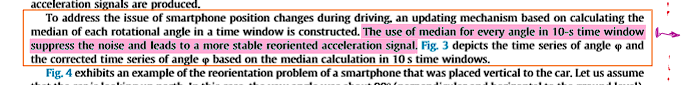

In [32]:
def rotate_acc_to_global_coord(data, window=None):
      '''
      Takes the dataset (where coarse_label == 5.0) and for each sub_segment, it get's the rotation matrix 
      (using the orientation sensor data), to rotate the accelerometer triaxal data to the global coordinates.
      Input:
            data: dataframe with appropriate labels
            window: the number of datapoints in each sub-segment
      Output:
            dataframe with appended columns (longitudinal acceleration, transversal acceleration corresponding to a'_x, a'_y)
      '''
      if window is None:
            window = data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()[0]
      
      ### The idea here is to halve the window (128) to 64 so as to adhere to info above;
      window = int(window/2)

      # get idx of columns in df
      cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
              'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']
      col_idx = [data.columns.get_loc(col) for col in cols]

      start = 0
      for i in range(0, int(len(data)/window), 1):
            end = start + window
            chunk = data.iloc[start:end, col_idx].copy() # gives me the needed columns

            # get rotation matrix and rotate acc vals to global coord
            R = get_rot_from_euler(chunk.iloc[:,3:]) # sends in only the orientation data and results in rotation matrix
            long_acc, tranv_acc = (chunk.iloc[:,:3] @ R)[0], (chunk.iloc[:,:3] @ R)[1]

            # attach values to df
            repl_idx_long = data.columns.get_loc('long_acc')
            repl_idx_tranv = data.columns.get_loc('tranv_acc')
            data.iloc[start:end, repl_idx_long] = long_acc
            data.iloc[start:end, repl_idx_tranv] = tranv_acc

            del chunk, long_acc, tranv_acc
            start = end

      return data

def get_angular_vel_from_gyr(data):
      '''
      Takes the dataset (where coarse_label == 5.0) and get's the angular velocity which corresponds to the square root of the sum of the
      squared gyroscope measurements
      Input:
            dataframe with appropriate labels
      Output:
            dataframe with appended columns (ang_vel)
      '''
      # get idx of columns in df
      cols = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']
      #col_idx = [data.columns.get_loc(col) for col in cols]
      
      # simply the sqrt of the sum of the squared gyro measurements
      ang_vel = np.sqrt(np.sum(data[cols]**2, axis=1))
      data['ang_vel'] = ang_vel

      return data

In [33]:
def get_long_tranv_angl(data):
      '''Gets the longitudinal acc, tranversal acc and angular velocity for coarse label == 5.0'''
      idx = data.query('Coarse_label == 5.0').index

      modified_data = get_angular_vel_from_gyr(rotate_acc_to_global_coord(data.loc[idx, :]))
      data.loc[idx, :] = modified_data

      return data

In [34]:
subbed_data = get_long_tranv_angl(subbed_data)

In [35]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81984 entries, 0 to 81983
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_ms         81984 non-null  float64
 1   acceleration_x  81984 non-null  float64
 2   acceleration_y  81984 non-null  float64
 3   acceleration_z  81984 non-null  float64
 4   gyroscope_x     81984 non-null  float64
 5   gyroscope_y     81984 non-null  float64
 6   gyroscope_z     81984 non-null  float64
 7   orientation_w   81984 non-null  float64
 8   orientation_x   81984 non-null  float64
 9   orientation_y   81984 non-null  float64
 10  orientation_z   81984 non-null  float64
 11  Date            81984 non-null  int64  
 12  Position        81984 non-null  object 
 13  Coarse_label    81984 non-null  float64
 14  Fine_label      81984 non-null  float64
 15  Segment         81984 non-null  int64  
 16  User            81984 non-null  object 
 17  Sub_Segment     81984 non-null 

In [36]:
subbed_data#.query('Coarse_label == 5.0')

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,...,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment,long_acc,tranv_acc,ang_vel
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,...,220617,Bag,5.0,9.0,5,User1,1,-2.350739,4.970239,0.064841
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,...,220617,Bag,5.0,9.0,5,User1,1,-2.452388,4.809790,0.052195
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,...,220617,Bag,5.0,9.0,5,User1,1,-2.618357,4.746866,0.024535
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,...,220617,Bag,5.0,9.0,5,User1,1,-2.543620,6.149348,0.021312
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,...,220617,Bag,5.0,9.0,5,User1,1,-2.742217,6.062677,0.040372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81979,1.497457e+12,-9.519346,-0.667579,1.855103,-0.016491,-0.055587,-0.010996,0.496516,-0.515839,0.372483,...,140617,Torso,7.0,15.0,33,User3,43,0.000000,0.000000,0.000000
81980,1.497457e+12,-9.628084,-0.666983,1.726616,0.022056,0.010866,-0.030013,0.496643,-0.517091,0.373129,...,140617,Torso,7.0,15.0,33,User3,43,0.000000,0.000000,0.000000
81981,1.497457e+12,-9.560941,-0.734126,1.985687,0.002953,-0.019577,-0.006734,0.497868,-0.515147,0.372450,...,140617,Torso,7.0,15.0,33,User3,43,0.000000,0.000000,0.000000
81982,1.497457e+12,-9.628085,-0.664193,1.838747,0.015256,0.041539,0.015226,0.496358,-0.516541,0.376265,...,140617,Torso,7.0,15.0,33,User3,43,0.000000,0.000000,0.000000


#### Training the Simple CNN for feature extraction
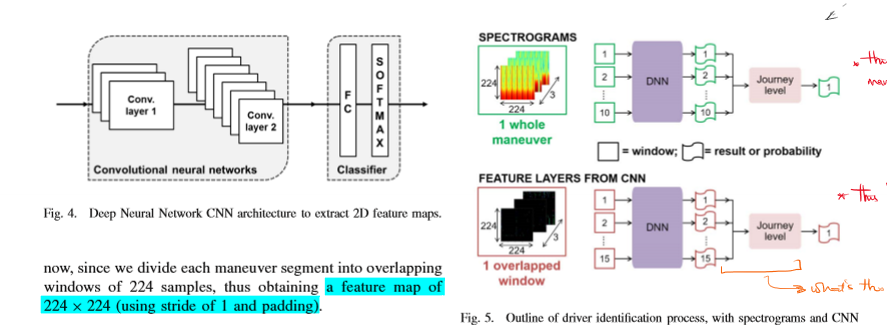

Get only the records associated with driving

In [37]:
subbed_data_Driver = subbed_data.query('Coarse_label == 5.0').copy()
subbed_data_Driver = subbed_data_Driver.reset_index(drop=True)

Remember that we're taking the different positions as different journeys in this case since that means for one trip, we could have 4 journeys since each user had 4 phones placed at different positions

In [38]:
print('Number of unique sub_segments')
print(subbed_data_Driver.groupby(['User', 'Segment'])[['Sub_Segment']].nunique()*4) # x4 for the 4 different positions

print('\nCount of data points in each segment')
print(subbed_data_Driver.groupby(['User', 'Segment'])[['Sub_Segment']].count()//4) # divided by 4 since we want to look at data pts for each position to

Number of unique sub_segments
               Sub_Segment
User  Segment             
User1 5                 28
      7                 24
      9                 12
User2 64                56
      66                 8
      70                20
      73                20

Count of data points in each segment
               Sub_Segment
User  Segment             
User1 5                784
      7                672
      9                336
User2 64              1568
      66               224
      70               560
      73               560


Since I would need to pass 224 long vector in and the sub-segments are of length 12, I'll need to join them together. 

**This code might change when I decide to work with a segment that has lotss of data. Will the 224 cover it?**

Edit later on:\
You don't need to pass in a 224 long vector. All you need to do is to split the each journey into 15 windows with 25% overlap. The 224x224 shape will be be created in the CNN layer.

My subsegment for the LSTM needs to be bigger. A vector of size 12 is too too small

-----
Working with the print out above, we have a reasonable amount of data for each journey. The least in this tiny sample is 128 but that'll increase when we use the main dataset. Now we'll combine the subsegments, calculate the window size based on each new comb_segment length so as break the segments into 15 windows with 25% overlap

In [39]:
import itertools

In [40]:
for i, j in itertools.product(subbed_data_Driver['User'].unique(), subbed_data_Driver['Position'].unique()):
      print(i,j)

User1 Bag
User1 Hand
User1 Hips
User1 Torso
User2 Bag
User2 Hand
User2 Hips
User2 Torso


In [41]:
def combine_sequences(subbed_data_Driver):
      '''Combine sub_segments into *segments for each journey. Where journey is defined as a trip for 
      each user at each segment for each position.

      *segments here doesn't represent the original segment since the data was already
      windowed down with overlap previously.
      '''
      combined_sequences = {}
      users = subbed_data_Driver['User'].unique()
      positions = subbed_data_Driver['Position'].unique()

      # iterate through each combination of user and positions
      for user, position in itertools.product(users, positions):
            # subset data
            user_data = subbed_data_Driver.query("User == @user & Position==@position")
            segments = user_data['Segment'].unique()
            # extract all required data for each segment
            for segment in segments:
                  segment_data = user_data.query("Segment == @segment")
                  long_acc = segment_data['long_acc'].values
                  tranv_acc = segment_data['tranv_acc'].values
                  ang_vel = segment_data['ang_vel'].values
                  
                  combined_sequences[(user, position, segment)] = {   
                        'long_acc': long_acc,
                        'tranv_acc': tranv_acc,
                        'ang_vel': ang_vel
                        }
      
      return combined_sequences


Calculate the window size for each combined_sequence and split into 15 windows with 25% overlap

-----
Decided to go back to getting 224 samples per journey because I need a fixed size during convolution

In [104]:
from scipy.interpolate import interp1d

def interpolate_to_length(array, target_length):
      '''Interpolate arrays that are smaller than 224 or window_size'''
      x = np.linspace(0, len(array) - 1, num=len(array))
      f = interp1d(x, array, kind='linear')
      x_new = np.linspace(0, len(array) - 1, num=target_length)
      interpolated_array = f(x_new)
      return interpolated_array

def create_windows(data, window_size, overlap):
      stride = int(window_size * (1 - overlap))
      num_windows = (len(data) - window_size) // stride + 1
      windows = np.array([data[i*stride:i*stride+window_size] for i in range(num_windows)])
      
      if len(windows) == 0:
            # occurs in cases when num_windows == 0 or -1 because len(data) <= window_size
            return np.array([interpolate_to_length(data, window_size)])
      
      # Check if the last window covers the end of the array by index
      last_window_end_index = (num_windows - 1) * stride + window_size - 1
      if last_window_end_index < len(data) - 1:
            last_start_index = len(data) - window_size
            last_window = data[last_start_index:]
            if len(last_window) < window_size:
                  last_window = interpolate_to_length(last_window, window_size)
            windows = list(windows)
            windows.append(last_window)
      
      return np.array(windows)

      # Check if the last window covers the end of the array, if not, add the remaining part
      if windows[-1][-1] != data[-1]:
            last_start_index = len(data) - window_size
            last_window = data[last_start_index:]
            if len(last_window) < window_size:
                  last_window = interpolate_to_length(last_window, window_size)
            windows = list(windows)
            windows.append(last_window)

      return np.array(windows)


Now decided to roll with a window size of 224 as usual (this captures two of the LSTM features) with no overlap. This means two things;
1. Even though there's 0% overlap, there still exists a sort of 50% overlap in the data so this should actually reduce the noise in the data
2. One time in put of CNN-GRU is equal to 2 of that of the biLSTM so I'll need a flag for each feature for the CNN-GRU so as to sync up both process.

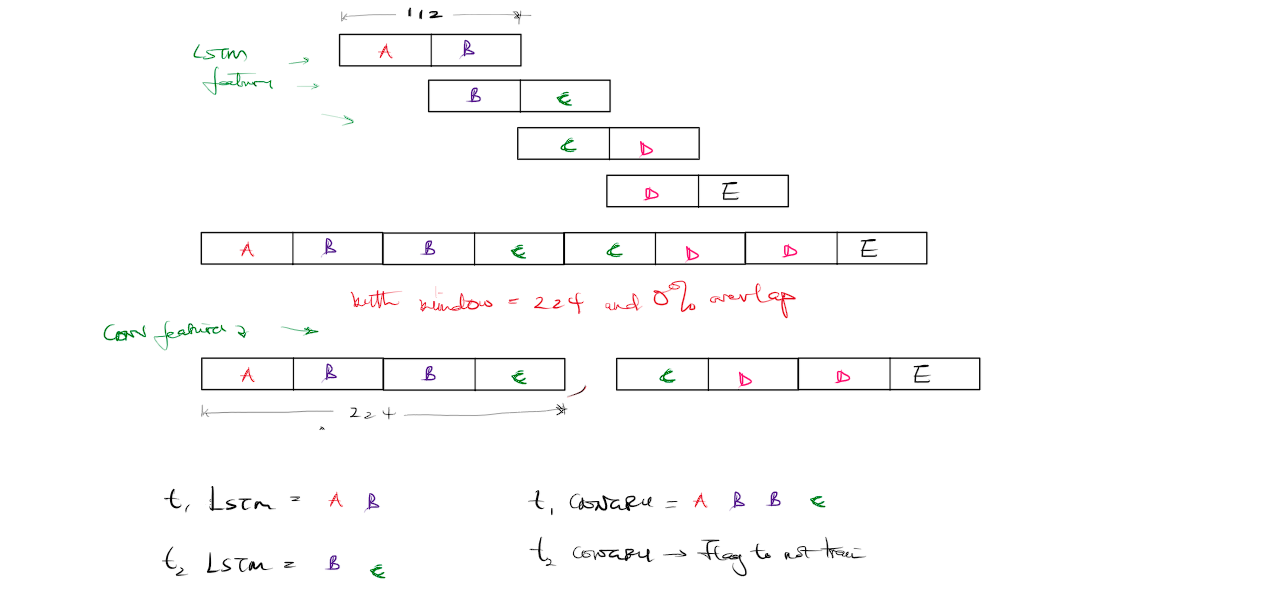

In [105]:
a = np.arange(0,112*10)
windows = create_windows(a, window_size=224, overlap=0)

for i,j in enumerate(windows):
      print(f'{i}: {j[0]}->{j[-1]} \t{len(j)}')

0: 0->223 	224
1: 224->447 	224
2: 448->671 	224
3: 672->895 	224
4: 896->1119 	224


In [106]:
def get_windowed_df(subbed_data_Driver, window_size=224, overlap=0.25):
      '''Creates a dataframe which contains each *segment sequentially divided into windows of a specific length'''
      windowed_data = []
      combined_sequences = combine_sequences(subbed_data_Driver)
      
      #c=0
      for (user, position, segment), signals in combined_sequences.items():
            long_windows = create_windows(signals['long_acc'], window_size, overlap)
            tranv_windows = create_windows(signals['tranv_acc'], window_size, overlap)
            ang_vel_windows = create_windows(signals['ang_vel'], window_size, overlap)

            for i in range(long_windows.shape[0]):
                  windowed_data.append({
                        'user': user,
                        'segment': segment,
                        'position': position,
                        'window_index': i,#+c,
                        'long_acc_window': long_windows[i],
                        'tranv_acc_window': tranv_windows[i],
                        'ang_vel_window': ang_vel_windows[i]
                  })

            #c+=(i+1)

      return pd.DataFrame(windowed_data)

In [107]:
windowed_df = get_windowed_df(subbed_data_Driver, window_size=224, overlap=0)

In [108]:
windowed_df

,user,segment,position,window_index,long_acc_window,tranv_acc_window,ang_vel_window
0,User1,5,Bag,0,"[-2.350738508209263, -2.4523884139699823, -2.6...","[4.970238810390384, 4.809790292450499, 4.74686...","[0.0648405923554065, 0.052195043538634966, 0.0..."
1,User1,5,Bag,1,"[-7.54751124871288, -6.926345963168818, -7.259...","[-6.231619256733537, -6.319429248221203, -6.26...","[0.02380094260738427, 0.019394921268208333, 0...."
2,User1,5,Bag,2,"[-3.8085620739669825, -3.8339059582538546, -3....","[-8.727795465870232, -8.934275164943962, -8.82...","[0.004702556432409928, 0.002400915242152459, 0..."
3,User1,5,Bag,3,"[-4.235678043242822, -4.201874033800579, -4.27...","[-8.449946624182521, -8.563958726233036, -8.50...","[0.006164662683391525, 0.005145401344890406, 0..."
4,User1,7,Bag,0,"[2.574750084096842, 2.276296485809965, 2.20979...","[9.885638820343415, 9.89389276093967, 9.827756...","[0.41780948318222744, 0.5182882404097164, 0.82..."
...,...,...,...,...,...,...,...
87,User2,70,Torso,1,"[8.874261084395108, 7.539388957628022, 8.02529...","[5.597841782255679, 5.5725910940068, 5.6925231...","[0.3512222796947825, 0.347244842458459, 0.6463..."
88,User2,70,Torso,2,"[1.9876182445367832, 1.9749827494277141, 2.061...","[-7.378507478159866, -7.522877072925625, -7.34...","[0.060302464070716044, 0.054894999125603416, 0..."
89,User2,73,Torso,0,"[-8.465738361367768, -8.910560720340508, -8.68...","[-4.292995935571669, -4.242100052587008, -4.60...","[0.561711412735223, 0.19096256199841893, 0.305..."
90,User2,73,Torso,1,"[-6.4293865515489586, -6.189176865519858, -6.3...","[-7.051187373893425, -7.006475049743672, -7.09...","[0.048272780497916216, 0.10622463308479818, 0...."


Confirming that we have the same our function works. What we want to see is that the number of 224 chunks (2 x LSTM features) for each user-position at each segment, while also considering that we're interpolating to 224 the cases where there's only one 112 pc remaining, is equal to the number of windowed pieces in window_df

In [47]:
users = windowed_df.user.unique()
positions = windowed_df.position.unique()
c = []
d = []

for user, position in itertools.product(users, positions):
      segments = subbed_data_Driver.query('User==@user & Position==@position').Segment.unique()
      for segment in segments:
            a = len(subbed_data_Driver.query('User==@user & Segment==@segment & Position==@position'))
            b = len(windowed_df.query("user==@user & segment==@segment & position==@position"))
            print(user, position, segment, '\t', int(np.ceil(a/224)), b)
            c.append(int(np.ceil(a/224)))
            d.append(b)

print(sum(c), sum(d))

User1 Bag 5 	 4 4
User1 Bag 7 	 3 3
User1 Bag 9 	 2 2
User1 Hand 5 	 4 4
User1 Hand 7 	 3 3
User1 Hand 9 	 2 2
User1 Hips 5 	 4 4
User1 Hips 7 	 3 3
User1 Hips 9 	 2 2
User1 Torso 5 	 4 4
User1 Torso 7 	 3 3
User1 Torso 9 	 2 2
User2 Bag 64 	 7 7
User2 Bag 66 	 1 1
User2 Bag 70 	 3 3
User2 Bag 73 	 3 3
User2 Hand 64 	 7 7
User2 Hand 66 	 1 1
User2 Hand 70 	 3 3
User2 Hand 73 	 3 3
User2 Hips 64 	 7 7
User2 Hips 66 	 1 1
User2 Hips 70 	 3 3
User2 Hips 73 	 3 3
User2 Torso 64 	 7 7
User2 Torso 66 	 1 1
User2 Torso 70 	 3 3
User2 Torso 73 	 3 3
92 92


In [48]:
np.unique([len(i) for i in windowed_df['long_acc_window']])

array([224])

Prepare the input for CNN

In [49]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [50]:
class SignalsDataset(Dataset):
      def __init__(self, data, labels, feature_index):
            """
            Args:
                  data (numpy.ndarray): The input data of shape (num_samples, num_features, window_size).
                  labels (numpy.ndarray): The labels for the data of shape (num_samples,).
                  feature_index (int): Index of the feature to use.
            """
            self.data = data[:, feature_index, :]  # Select the specified feature
            self.labels = labels

      def __len__(self):
            return len(self.data)

      def __getitem__(self, idx):
            x = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            y = torch.tensor(self.labels[idx], dtype=torch.long)
            return x, y

In [51]:
def prep_input_for_CNN(windowed_df):
      X = []
      y = []

      for index, row in windowed_df.iterrows():
            long_acc_window = row['long_acc_window']
            tranv_acc_window = row['tranv_acc_window']
            ang_vel_window = row['ang_vel_window']
            combined_window = np.stack([long_acc_window, tranv_acc_window, ang_vel_window], axis=0)
            X.append(combined_window)
            y.append(row['user'])

      X = np.array(X)
      y_lab = np.array(y)
      _, y = np.unique(y_lab, return_inverse=True)
      return X, y

In [52]:
X, y = prep_input_for_CNN(windowed_df)

In [53]:
X.shape

(92, 3, 224)

In [54]:
# Check the first row, long_acc_window of both X and dataframe to see if there's a difference
np.sum(X[0][0] != windowed_df['long_acc_window'][0])

0

In [55]:
# X.shape = (num_samples, channels (3), 224)
# y.shape = (num_samples, )
print(X.shape)
print(y.shape)

(92, 3, 224)
(92,)


In [56]:
np.bincount(y)

array([36, 56], dtype=int64)

In [57]:
# Perform a train-test split
np.random.seed(1)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr)

# normalizing X
mean = X_train.mean(axis=(0, 2), keepdims=True)
std = X_train.std(axis=(0, 2), keepdims=True)

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [58]:
# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

train_datasets = {feature: SignalsDataset(X_train, y_train, idx) for feature, idx in feature_indices.items()}
valid_datasets = {feature: SignalsDataset(X_valid, y_valid, idx) for feature, idx in feature_indices.items()}
test_datasets = {feature: SignalsDataset(X_test, y_test, idx) for feature, idx in feature_indices.items()}

## dataset for extracting feature maps from data
all_dataset = {feature: SignalsDataset((X-mean)/std, y, idx) for feature, idx in feature_indices.items()}

In [59]:
train_datasets

{'long_acc': <__main__.SignalsDataset at 0x1a6c78309a0>,
 'tranv_acc': <__main__.SignalsDataset at 0x1a6c7830f40>,
 'ang_vel': <__main__.SignalsDataset at 0x1a6c78311e0>}

In [60]:
np.random.seed(1)

batch_size = 1
train_dl_long = DataLoader(train_datasets['long_acc'], batch_size, shuffle=True)
train_dl_tranv = DataLoader(train_datasets['tranv_acc'], batch_size, shuffle=True)
train_dl_angvel = DataLoader(train_datasets['ang_vel'], batch_size, shuffle=True)

valid_dl_long = DataLoader(valid_datasets['long_acc'], batch_size, shuffle=False)
valid_dl_tranv = DataLoader(valid_datasets['tranv_acc'], batch_size, shuffle=False)
valid_dl_angvel = DataLoader(valid_datasets['ang_vel'], batch_size, shuffle=False)

test_dl_long = DataLoader(test_datasets['long_acc'], batch_size, shuffle=False)
test_dl_tranv = DataLoader(test_datasets['tranv_acc'], batch_size, shuffle=False)
test_dl_angvel = DataLoader(test_datasets['ang_vel'], batch_size, shuffle=False)

In [61]:
# Check the shape of the data in DataLoader
for x, y in train_dl_long:
    print(x.shape)  # Expected: torch.Size([1, 1, 224])
    print(y.shape)  # Expected: torch.Size([1])
    break  # Only check the first batch

torch.Size([1, 1, 224])
torch.Size([1])


Simple CNN model

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Going back above to make sure my data is in this format;

`conv1d()` takes `[Batch_size, Channels_in, Length]` and outputs `[Batch_size, Channels_out, Length_out]`\
`conv2d()` takes `[Batch_size, Channels_in, H, W]` and outputs `[Batch_size, Channels_out, H_out, W_out]`


<font color='yellow'>An idea for improvement of feature maps is to increase the window length from 224. But that's later on</font>

In [63]:
class SimpleCNN(nn.Module):
      def __init__(self):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=224, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(in_channels=224, out_channels=224, kernel_size=3, padding=1)
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(224 * 224, 1)  # Fully connected layer for classification

      def forward(self, x):
            x = F.relu(self.conv1(x))  # Apply ReLU activation after Conv1d
            x = x.unsqueeze(2) # Add dimension for Conv2d: (batch_size, channels, 1, length)
            x = F.relu(self.conv2(x))  # Apply ReLU activation after Conv2d
            x = self.flatten(x)  # Flatten the tensor
            x = self.fc(x)  # Fully connected layer
            x = F.sigmoid(x)
            return x

In [97]:
model_long = SimpleCNN()
model_tranv = SimpleCNN()
model_ang = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)
model_tranv = model_tranv.to(device)
model_ang = model_ang.to(device)


loss_fn = nn.BCELoss()

optimizer_long = torch.optim.SGD(model_long.parameters(), lr=0.0001)
optimizer_tranv = torch.optim.SGD(model_tranv.parameters(), lr=0.001)
optimizer_ang = torch.optim.SGD(model_ang.parameters(), lr=0.0001)

Define training function

In [98]:
def train(model, optimizer, num_epochs, train_dl, valid_dl, save_path=None):
      loss_hist_train = [0] * num_epochs
      accuracy_hist_train = [0] * num_epochs
      loss_hist_valid = [0] * num_epochs
      accuracy_hist_valid = [0] * num_epochs

      for epoch in range(num_epochs):
            model.train()
            for x_batch, y_batch in train_dl:
                  x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                  pred = model(x_batch)[:, 0]
                  loss = loss_fn(pred, y_batch.float())
                  loss.backward()
                  optimizer.step()
                  optimizer.zero_grad()
                  loss_hist_train[epoch] += loss.item()*y_batch.size(0)
                  is_correct = ((pred>=0.5).float() == y_batch).float()
                  accuracy_hist_train[epoch] += is_correct.sum().cpu()
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)

            model.eval()
            with torch.no_grad():
                  for x_batch, y_batch in valid_dl:
                        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                        pred = model(x_batch)[:, 0]
                        loss = loss_fn(pred, y_batch.float())
                        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                        is_correct = ((pred>=0.5).float() == y_batch).float()
                        accuracy_hist_valid[epoch] += is_correct.sum().cpu()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

            print(f'Epoch {epoch+1} accuracy: '
                  f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
                  f'{accuracy_hist_valid[epoch]:.4f}')
            
      # Save checkpoint
      if save_path:
            #save_path = 'model_checkpoint.pth'
            torch.save({
                  #'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
            }, save_path)
            
      return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid


In [154]:
torch.manual_seed(1)
num_epochs = 30

long_hist = train(model_long, optimizer_long, num_epochs, train_dl_long, valid_dl_long, save_path='./model_checkpoint/112_model_long2d.pth')
np.save('./model_checkpoint/112_long_hist_train_history.npy', np.array(long_hist))

Epoch 1 accuracy: 0.5690 val_accuracy: 0.6000
Epoch 2 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 3 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 4 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 5 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 6 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 7 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 8 accuracy: 0.6034 val_accuracy: 0.6000
Epoch 9 accuracy: 0.6207 val_accuracy: 0.6000
Epoch 10 accuracy: 0.6034 val_accuracy: 0.5333
Epoch 11 accuracy: 0.5690 val_accuracy: 0.5333
Epoch 12 accuracy: 0.6552 val_accuracy: 0.5333
Epoch 13 accuracy: 0.5862 val_accuracy: 0.5333
Epoch 14 accuracy: 0.5862 val_accuracy: 0.5333
Epoch 15 accuracy: 0.6552 val_accuracy: 0.5333
Epoch 16 accuracy: 0.6379 val_accuracy: 0.6000
Epoch 17 accuracy: 0.6379 val_accuracy: 0.5333
Epoch 18 accuracy: 0.6379 val_accuracy: 0.6000
Epoch 19 accuracy: 0.6552 val_accuracy: 0.6000
Epoch 20 accuracy: 0.6379 val_accuracy: 0.6000
Epoch 21 accuracy: 0.6724 val_accuracy: 0.6000
Epoch 22 accuracy: 0.6

In [155]:
torch.manual_seed(1)
num_epochs = 30

tranv_hist = train(model_tranv, optimizer_tranv, num_epochs, train_dl_tranv, valid_dl_tranv, save_path='./model_checkpoint/112_model_tranv2d.pth')
np.save('./model_checkpoint/112_tranv_hist_train_history.npy', np.array(tranv_hist))

Epoch 1 accuracy: 0.4828 val_accuracy: 0.6000
Epoch 2 accuracy: 0.5517 val_accuracy: 0.5333
Epoch 3 accuracy: 0.6552 val_accuracy: 0.5333
Epoch 4 accuracy: 0.6207 val_accuracy: 0.5333
Epoch 5 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 6 accuracy: 0.6552 val_accuracy: 0.5333
Epoch 7 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 8 accuracy: 0.6379 val_accuracy: 0.5333
Epoch 9 accuracy: 0.6552 val_accuracy: 0.5333
Epoch 10 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 11 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 12 accuracy: 0.7069 val_accuracy: 0.5333
Epoch 13 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 14 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 15 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 16 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 17 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 18 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 19 accuracy: 0.7069 val_accuracy: 0.5333
Epoch 20 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 21 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 22 accuracy: 0.6

In [157]:
torch.manual_seed(1)
num_epochs = 30

ang_hist = train(model_ang, optimizer_ang, num_epochs, train_dl_angvel, valid_dl_angvel, save_path='./model_checkpoint/112_model_angvel2d.pth')
np.save('./model_checkpoint/112_ang_vel_train_history.npy', np.array(ang_hist))

Epoch 1 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 2 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 3 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 4 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 5 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 6 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 7 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 8 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 9 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 10 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 11 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 12 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 13 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 14 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 15 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 16 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 17 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 18 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 19 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 20 accuracy: 0.6897 val_accuracy: 0.5333
Epoch 21 accuracy: 0.6724 val_accuracy: 0.5333
Epoch 22 accuracy: 0.6

In [158]:
import matplotlib.pyplot as plt

In [159]:
def plot_history(hist):
      x_arr = np.arange(len(hist[0])) + 1

      fig = plt.figure(figsize=(12, 4))
      ax = fig.add_subplot(1, 2, 1)
      ax.plot(x_arr, hist[0], '-o', label='Train loss')
      ax.plot(x_arr, hist[1], '--<', label='Validation loss')
      ax.legend(fontsize=15)
      ax.set_xlabel('Epoch', size=15)
      ax.set_ylabel('Loss', size=15)

      ax = fig.add_subplot(1, 2, 2)
      ax.plot(x_arr, hist[2], '-o', label='Train acc.')
      ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
      ax.legend(fontsize=15)
      ax.set_xlabel('Epoch', size=15)
      ax.set_ylabel('Accuracy', size=15)

      #plt.savefig('figures/14_17.png', dpi=300)
      plt.show()

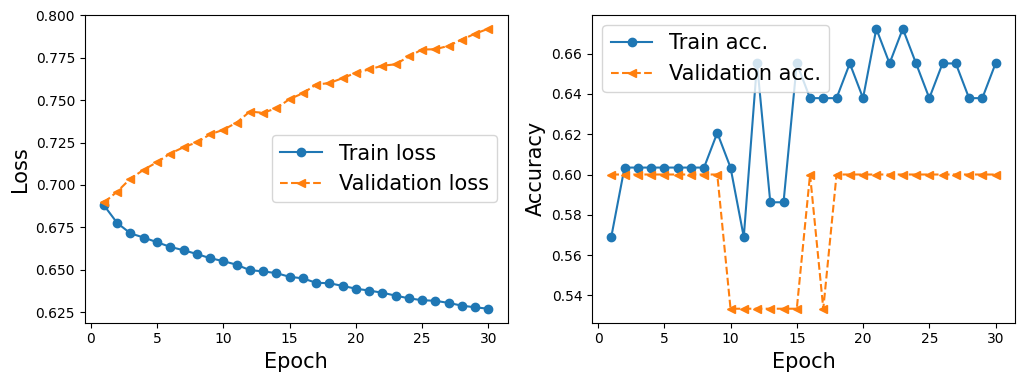

In [160]:
plot_history(long_hist)

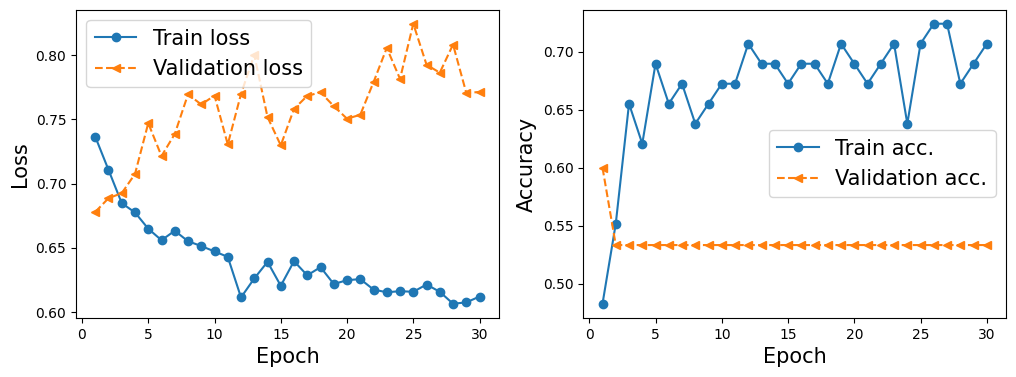

In [161]:
plot_history(tranv_hist)

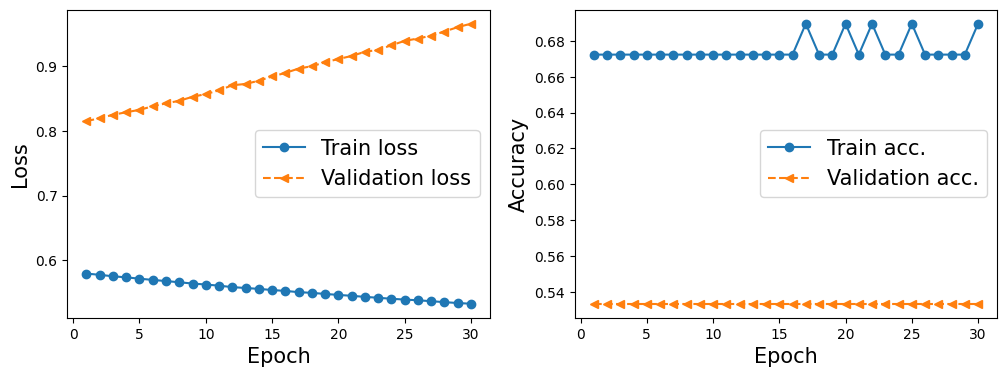

In [162]:
plot_history(ang_hist)

Probably would be better when we have more data. Currently, our training data and validation is small.

---

### Test Phase

In [64]:
model_long = SimpleCNN()
model_tranv = SimpleCNN()
model_ang = SimpleCNN()

In [65]:
# # Load the checkpoint
# checkpoint = torch.load('model_checkpoint.pth')

# # Load the model state
# model.load_state_dict(checkpoint['model_state_dict'])

# # Load the optimizer state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Load the loss
# loss = checkpoint['loss']

# print(f'Loaded model and optimizer state from checkpoint with loss: {loss}')

In [66]:
# Load the checkpoint
long_checkpoint = torch.load('./model_checkpoint/112_model_long2d.pth')
trnv_checkpoint = torch.load('./model_checkpoint/112_model_tranv2d.pth')
angvel_checkpoint = torch.load('./model_checkpoint/112_model_angvel2d.pth')

model_long.load_state_dict(long_checkpoint['model_state_dict'])
model_tranv.load_state_dict(trnv_checkpoint['model_state_dict'])
model_ang.load_state_dict(angvel_checkpoint['model_state_dict'])

<All keys matched successfully>

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)
model_tranv = model_tranv.to(device)
model_ang = model_ang.to(device)

In [68]:
len(X_train)

58

In [69]:
correct_agreements = 0
total_samples = 0

# Iterate through the test data loaders simultaneously
for (x_long, y_long), (x_tranv, y_tranv), (x_angvel, y_angvel) in zip(test_dl_long, test_dl_tranv, test_dl_angvel):
      # Transfer data to device
      x_long, y_long = x_long.to(device), y_long.to(device)
      x_tranv, y_tranv = x_tranv.to(device), y_tranv.to(device)
      x_angvel, y_angvel = x_angvel.to(device), y_angvel.to(device)

      # Assuming each model outputs probabilities (sigmoid output)
      with torch.no_grad():
            pred_long = model_long(x_long)
            pred_tranv = model_tranv(x_tranv)
            pred_angvel = model_ang(x_angvel)

      # Combine predictions (average probabilities)
      pred_combined = (pred_long + pred_tranv + pred_angvel) / 3

      # Apply threshold (convert probabilities to binary predictions)
      pred_label = (pred_combined > 0.5).float()  # 1 if probability > 0.5, else 0

      # Compare with ground truth label y_long (assuming all y_long, y_tranv, y_angvel are the same for a sample)
      correct_agreements += torch.sum(pred_label == y_long).item()

      total_samples += x_long.size(0)  # Increment total samples processed

# Calculate accuracy
accuracy = correct_agreements / total_samples
print(f"Agreement accuracy among models: {accuracy}")


Agreement accuracy among models: 0.631578947368421


In [70]:
total_samples

19

### Feature Map Extraction

In [71]:
# Function to extract feature map
def get_feature_map(model, x_batch):
      # Place model in evaluation mode
      model.eval()
      
      # Hook to store the feature map
      feature_maps = []

      # Define a hook function to capture the feature map
      def hook(module, input, output):
            feature_maps.append(output.detach().cpu().numpy())

      # Register the hook to the desired layer
      hook_handle = model.conv2.register_forward_hook(hook)

      try:
            # Run the data through the model to trigger the hook
            with torch.no_grad():
                  model(x_batch)
      finally:
            # Remove the hook after feature extraction
            hook_handle.remove()

      return feature_maps[0]


def feature_map_extractor(model, dataloader):
      '''Extracts the feature maps from the model and returns it as well as the corresponding labels'''
      feature_maps_list = []
      y_lab = []

      for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            f_maps = get_feature_map(model, x_batch)
            
            # Append feature maps and labels
            feature_maps_list.append(f_maps)
            y_lab.append(y_batch.numpy())

      # Concatenate all feature maps and labels into single arrays
      feature_maps_array = np.concatenate(feature_maps_list, axis=0)
      y_lab_array = np.concatenate(y_lab, axis=0)

      return feature_maps_array, y_lab_array

In [72]:
import seaborn as sns

# Normalize the feature maps to [0, 1] range for visualization
def normalize_feature_map(feature_map):
      feature_map_min = feature_map.min(axis=(2, 3), keepdims=True)
      feature_map_max = feature_map.max(axis=(2, 3), keepdims=True)
      normalized_feature_map = (feature_map - feature_map_min) / (feature_map_max - feature_map_min + 1e-8)
      return normalized_feature_map

# visualize feature map
def feature_map_heatmap(feature_map, cmap='viridis'):
      normalized_feature_map = normalize_feature_map(feature_map)

      sns.heatmap(np.squeeze(normalized_feature_map), cmap='viridis')

-----

At this point, in order to make sure that there's sort of a sync between the data feed to both branches of my MTL model, I'd have to make sure that they both look at the same time portion albeit at different data formats. The current format for the features and labels for LSTM are complete as all data are represented. However for the ResNet50-GRU, we've only selected driving data. This means that the features and labels for this are significantly smaller. We'll have to represent left out data as a zeros of the same format so as to make both data the same size and time sync the data when loading it into the model. 

The aim of this is to be able to better inteprete the results from our MTL model. Given a specific data (regardless of its representation) which represents a specific time section of sensor data, the model should tell us which driver it is or if it's not even driving data. This requires the data to represent the same time. Do you get?

This however doesn't present a problem, implementation-wise, as our window was defined when we made sub-segments of 128 datapoints with 50% overlap at the beginning. We used this segmentation when creating our LSTM features and also our feature maps for the CNN-GRU. So all we need to find out are the idx of the values, when creating the LSTM, that are not driving data.

-----

Firstly, I'll have to add the flags to the LSTM data and the placeholder data as well as flags

In [73]:
# Create DataLoaders
batch_size = 1
dataloaders = {
      'long': [DataLoader(all_dataset['long_acc'], batch_size, shuffle=False)],
      'tranv': [DataLoader(all_dataset['tranv_acc'], batch_size, shuffle=False)],
      'angvel': [DataLoader(all_dataset['ang_vel'], batch_size, shuffle=False)]
}

## save sequence info
sequence_info = windowed_df.iloc[:,:4] # saves the user id, segment id, position and window idx

In [74]:
# Models
models = {
      'long': model_long,
      'tranv': model_tranv,
      'angvel': model_ang
}

# Feature maps and labels storage
feature_maps = {'long': [], 'tranv': [], 'angvel': []}
labels = {'long': [], 'tranv': [], 'angvel': []}

# Extract feature maps and labels
for key in dataloaders.keys():
      for dl in dataloaders[key]:
            fmaps, ylabs = feature_map_extractor(models[key], dl)
            feature_maps[key].append(fmaps)
            labels[key].append(ylabs)

# Concatenate feature maps and labels
for key in feature_maps.keys():
      feature_maps[key] = np.concatenate(feature_maps[key], axis=0)
      labels[key] = np.concatenate(labels[key], axis=0)

# Feature maps and labels are now stored in:
# feature_maps['long'], feature_maps['tranv'], feature_maps['angvel']
# labels['long'], labels['tranv'], labels['angvel']

In [75]:
labels['long'] == labels['tranv']  & labels['angvel']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [76]:
feature_maps['long'][0].shape

(224, 1, 224)

For the feature maps, the placeholders will have to be of the same shape the feature_maps data

In [77]:
print(X[0,:,0:3])
windowed_df

[[-2.35073851 -2.45238841 -2.6183566 ]
 [ 4.97023881  4.80979029  4.74686593]
 [ 0.06484059  0.05219504  0.02453535]]


,user,segment,position,window_index,long_acc_window,tranv_acc_window,ang_vel_window
0,User1,5,Bag,0,"[-2.350738508209263, -2.4523884139699823, -2.6...","[4.970238810390384, 4.809790292450499, 4.74686...","[0.0648405923554065, 0.052195043538634966, 0.0..."
1,User1,5,Bag,1,"[-7.54751124871288, -6.926345963168818, -7.259...","[-6.231619256733537, -6.319429248221203, -6.26...","[0.02380094260738427, 0.019394921268208333, 0...."
2,User1,5,Bag,2,"[-3.8085620739669825, -3.8339059582538546, -3....","[-8.727795465870232, -8.934275164943962, -8.82...","[0.004702556432409928, 0.002400915242152459, 0..."
3,User1,5,Bag,3,"[-4.235678043242822, -4.201874033800579, -4.27...","[-8.449946624182521, -8.563958726233036, -8.50...","[0.006164662683391525, 0.005145401344890406, 0..."
4,User1,7,Bag,0,"[2.574750084096842, 2.276296485809965, 2.20979...","[9.885638820343415, 9.89389276093967, 9.827756...","[0.41780948318222744, 0.5182882404097164, 0.82..."
...,...,...,...,...,...,...,...
87,User2,70,Torso,1,"[8.874261084395108, 7.539388957628022, 8.02529...","[5.597841782255679, 5.5725910940068, 5.6925231...","[0.3512222796947825, 0.347244842458459, 0.6463..."
88,User2,70,Torso,2,"[1.9876182445367832, 1.9749827494277141, 2.061...","[-7.378507478159866, -7.522877072925625, -7.34...","[0.060302464070716044, 0.054894999125603416, 0..."
89,User2,73,Torso,0,"[-8.465738361367768, -8.910560720340508, -8.68...","[-4.292995935571669, -4.242100052587008, -4.60...","[0.561711412735223, 0.19096256199841893, 0.305..."
90,User2,73,Torso,1,"[-6.4293865515489586, -6.189176865519858, -6.3...","[-7.051187373893425, -7.006475049743672, -7.09...","[0.048272780497916216, 0.10622463308479818, 0...."


The values in X, when unshuffled, correspond to the values in windowed_df which is a function of the driving data subset of `subbed_data`. Let's apply the `get_windowed_df` to `subbed_data` so as to get the index's which are missing. 

In order to match what we order that the biLSTM features were made i.e. time-wise, we'll have to look at the following grouping below;

In [78]:
subbed_data.groupby(['User', 'Position', 'Segment']).count().cumsum()

time_ms  acceleration_x  acceleration_y  \
User  Position Segment                                            
User1 Bag      5            784             784             784   
               6           1232            1232            1232   
               7           1904            1904            1904   
               8           2464            2464            2464   
               9           2800            2800            2800   
...                         ...             ...             ...   
User3 Torso    25         80080           80080           80080   
               28         80528           80528           80528   
               29         81312           81312           81312   
               31         81424           81424           81424   
               33         81984           81984           81984   

                        acceleration_z  gyroscope_x  gyroscope_y  gyroscope_z  \
User  Position Segment                                                          
User1 Bag      5                   784          784          784          784   
               6                  1232         1232         1232         1232   
               7                  1904         1904         1904         1904   
               8                  2464         2464         2464         2464   
               9                  2800         2800         2800         2800   
...                                ...          ...          ...          ...   
User3 Torso    25                80080        80080        80080        80080   
               28                80528        80528        80528        80528   
               29                81312        81312        81312        81312   
               31                81424        81424        81424        81424   
               33                81984        81984        81984        81984   

                        orientation_w  orientation_x  orientation_y  \
User  Position Segment                                                
User1 Bag      5                  784            784            784   
               6                 1232           1232           1232   
               7                 1904           1904           1904   
               8                 2464           2464           2464   
               9                 2800           2800           2800   
...                               ...            ...            ...   
User3 Torso    25               80080          80080          80080   
               28               80528          80528          80528   
               29               81312          81312          81312   
               31               81424          81424          81424   
               33               81984          81984          81984   

                        orientation_z   Date  Coarse_label  Fine_label  \
User  Position Segment                                                   
User1 Bag      5                  784    784           784         784   
               6                 1232   1232          1232        1232   
               7                 1904   1904          1904        1904   
               8                 2464   2464          2464        2464   
               9                 2800   2800          2800        2800   
...                               ...    ...           ...         ...   
User3 Torso    25               80080  80080         80080       80080   
               28               80528  80528         80528       80528   
               29               81312  81312         81312       81312   
               31               81424  81424         81424       81424   
               33               81984  81984         81984       81984   

                        Sub_Segment  long_acc  tranv_acc  ang_vel  
User  Position Segment                                             
User1 Bag      5                784       784        784      784  
       

In [79]:
idx_grp = subbed_data.groupby(['User', 'Position', 'Segment'])['time_ms'].count().cumsum().values

As we can see, going with this idx grouping gives us data of the same data, coarse_label and segment. 

In [80]:
subbed_data.iloc[:784,:].groupby(['User', 'Position', 'Segment']).nunique()

,,,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Coarse_label,Fine_label,Sub_Segment,long_acc,tranv_acc,ang_vel
User,Position,Segment,,,,,,,,,,,,,,,,,,
User1,Bag,5,448,448,440,447,408,437,343,407,396,423,421,1,1,1,7,448,448,448


Recall that we want an overlapped=0

In [81]:
len(idx_grp)

200

In [146]:
full_windowed_df = pd.DataFrame(columns=list(windowed_df.columns).append('window_idx'))

start_idx = 0
for end_idx in idx_grp:
      win_df = get_windowed_df(subbed_data.iloc[start_idx:end_idx].reset_index(drop=True), 
                               window_size=224, overlap=0)
      win_df['window_idx'] = end_idx
      full_windowed_df = pd.concat((full_windowed_df, win_df))
      start_idx = end_idx

full_windowed_df = full_windowed_df.reset_index(drop=True)

In [147]:
len(full_windowed_df['long_acc_window'][0]), len(full_windowed_df)

(224, 428)

Going through index group (segment), find the ones where the middle "B" arrays are the last arrays is equal to the first of the next one. This should return the idx for the row which contains linear interpolated values.

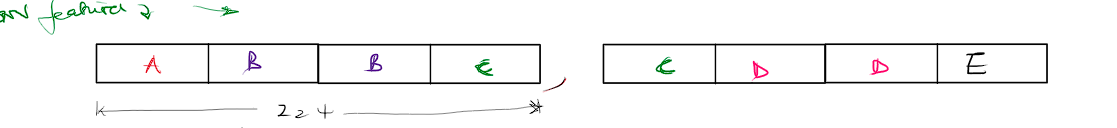

Or better still we could use the method below. We can see that the ones with remainder after division by a window of 224 had its last chunk of 112 interpolated to 224

In [148]:
users = windowed_df.user.unique()
positions = windowed_df.position.unique()
sections_interpltd = []
c = []
d = []

for user, position in itertools.product(users, positions):
      segments = subbed_data_Driver.query('User==@user & Position==@position').Segment.unique()
      for segment in segments:
            a = len(subbed_data_Driver.query('User==@user & Segment==@segment & Position==@position'))
            b = len(windowed_df.query("user==@user & segment==@segment & position==@position"))
            print(user, position, segment, '\t', a/224, b)
            c.append(int(np.ceil(a/224)))
            d.append(b)

            if a/224 != b:
                  sections_interpltd.append((user, position, segment))



print(sum(c), sum(d))
print('Interpol:', len(sections_interpltd))

User1 Bag 5 	 3.5 4
User1 Bag 7 	 3.0 3
User1 Bag 9 	 1.5 2
User1 Hand 5 	 3.5 4
User1 Hand 7 	 3.0 3
User1 Hand 9 	 1.5 2
User1 Hips 5 	 3.5 4
User1 Hips 7 	 3.0 3
User1 Hips 9 	 1.5 2
User1 Torso 5 	 3.5 4
User1 Torso 7 	 3.0 3
User1 Torso 9 	 1.5 2
User2 Bag 64 	 7.0 7
User2 Bag 66 	 1.0 1
User2 Bag 70 	 2.5 3
User2 Bag 73 	 2.5 3
User2 Hand 64 	 7.0 7
User2 Hand 66 	 1.0 1
User2 Hand 70 	 2.5 3
User2 Hand 73 	 2.5 3
User2 Hips 64 	 7.0 7
User2 Hips 66 	 1.0 1
User2 Hips 70 	 2.5 3
User2 Hips 73 	 2.5 3
User2 Torso 64 	 7.0 7
User2 Torso 66 	 1.0 1
User2 Torso 70 	 2.5 3
User2 Torso 73 	 2.5 3
92 92
Interpol: 16


For these sections, we know that the last row was linearly interpolated that means there's no need to create an empty placeholder after it. For example in the case of;

`[A, B, B, C, C, D, D, E, E, F]` assuming that the letters are 56, that means splitting to 224 with 0% over lap will result in `[A, B, B, C]`; `[C, D, D, E]` and `[EF]-interpolated`. This will correspond to `[A, B]`; `[B, C]`; `[C, D]`, `[D, E]` and `[E, F]` in the biLSTM features. Notice that one feature of CNN-GRU covers two of LSTM in all cases except for when interpolated, it covers just onez

If we wanted to sync in time the data from window_df and the lstm features from subbed_data_driver, let's see how much of window_df will need to be duplicated;

In [149]:
sections_interpltd

[('User1', 'Bag', 5),
 ('User1', 'Bag', 9),
 ('User1', 'Hand', 5),
 ('User1', 'Hand', 9),
 ('User1', 'Hips', 5),
 ('User1', 'Hips', 9),
 ('User1', 'Torso', 5),
 ('User1', 'Torso', 9),
 ('User2', 'Bag', 70),
 ('User2', 'Bag', 73),
 ('User2', 'Hand', 70),
 ('User2', 'Hand', 73),
 ('User2', 'Hips', 70),
 ('User2', 'Hips', 73),
 ('User2', 'Torso', 70),
 ('User2', 'Torso', 73)]

We have 16 interpolated sections. This means that these sections wouldn't need to be duplicated.

In [150]:
# represents our LSTM features for driving data
len(subbed_data_Driver)//112

168

In [151]:
# represents the time synced data for window_df after only the parts which aren't interpolated are duplicated.
92*2 - (16)

168

Now that this is settled, the plan is to apply this to `full_windowed_df`;
* Find the sections which are interpolated by looking at `subbed_data` instead
* Get the user, position and segment for these sections,
* The interpolated rows in `full_windowed_df` will be the last row of the sections of interest
* Duplicate all other rows

In [152]:
subbed_data.columns

Index(['time_ms', 'acceleration_x', 'acceleration_y', 'acceleration_z',
       'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'orientation_w',
       'orientation_x', 'orientation_y', 'orientation_z', 'Date', 'Position',
       'Coarse_label', 'Fine_label', 'Segment', 'User', 'Sub_Segment',
       'long_acc', 'tranv_acc', 'ang_vel'],
      dtype='object')

* Find the sections which are interpolated by looking at `subbed_data` instead
* Get the user, position and segment for these sections,

In [153]:
# Like the code above, let's iterate over the full data (subbed_data) to see which of the sections have
# remainders when divided by 224. Those will be flagged as interpolated 

users = subbed_data.User.unique()
positions = subbed_data.Position.unique()
sections_interpltd = []
c = []
d = []

for user, position in itertools.product(users, positions):
      coarse_labels = subbed_data.query('User==@user & Position==@position').Coarse_label.unique()
      for coarse_label in coarse_labels:
            segments = subbed_data.query('User==@user & Position==@position & Coarse_label==@coarse_label').Segment.unique()
            for segment in segments:
                  a = len(subbed_data.query('User==@user & Segment==@segment & Position==@position & Coarse_label==@coarse_label'))
                  #b = len(windowed_df.query("user==@user & segment==@segment & position==@position"))
                  #c.append(int(np.ceil(a/224)))
                  #d.append(b)

                  if (a % 224) != 0 :
                        print(user, position, segment, coarse_label, '\t', a/224)
                        sections_interpltd.append((user, position, segment, coarse_label))


User1 Bag 5 5.0 	 3.5
User1 Bag 9 5.0 	 1.5
User1 Bag 8 2.0 	 2.5
User1 Bag 10 3.0 	 0.5
User1 Bag 17 6.0 	 1.5
User1 Bag 24 4.0 	 0.5
User1 Bag 31 4.0 	 0.5
User1 Bag 33 7.0 	 3.5
User1 Bag 37 8.0 	 4.5
User1 Hand 5 5.0 	 3.5
User1 Hand 9 5.0 	 1.5
User1 Hand 8 2.0 	 2.5
User1 Hand 10 3.0 	 0.5
User1 Hand 17 6.0 	 1.5
User1 Hand 24 4.0 	 0.5
User1 Hand 31 4.0 	 0.5
User1 Hand 33 7.0 	 3.5
User1 Hand 37 8.0 	 4.5
User1 Hips 5 5.0 	 3.5
User1 Hips 9 5.0 	 1.5
User1 Hips 8 2.0 	 2.5
User1 Hips 10 3.0 	 0.5
User1 Hips 17 6.0 	 1.5
User1 Hips 24 4.0 	 0.5
User1 Hips 31 4.0 	 0.5
User1 Hips 33 7.0 	 3.5
User1 Hips 37 8.0 	 4.5
User1 Torso 5 5.0 	 3.5
User1 Torso 9 5.0 	 1.5
User1 Torso 8 2.0 	 2.5
User1 Torso 10 3.0 	 0.5
User1 Torso 17 6.0 	 1.5
User1 Torso 24 4.0 	 0.5
User1 Torso 31 4.0 	 0.5
User1 Torso 33 7.0 	 3.5
User1 Torso 37 8.0 	 4.5
User2 Bag 24 2.0 	 0.5
User2 Bag 33 2.0 	 0.5
User2 Bag 9 1.0 	 0.5
User2 Bag 14 6.0 	 0.5
User2 Bag 21 6.0 	 0.5
User2 Bag 58 6.0 	 0.5
User2 Bag 2

In [154]:
# # Like the code above, let's iterate over the full data (subbed_data) to see which of the sections have
# # remainders when divided by 224. Those will be flagged as interpolated 

# users = full_windowed_df.user.unique()
# positions = full_windowed_df.position.unique()
# sections_interpltd = []
# c = []
# d = []

# for user, position in itertools.product(users, positions):
#       segments = subbed_data.query('User==@user & Position==@position').Segment.unique()
#       for segment in segments:
#             a = len(subbed_data.query('User==@user & Segment==@segment & Position==@position'))
#             b = len(full_windowed_df.query("user==@user & segment==@segment & position==@position"))
#             print(user, position, segment, '\t', a/224, b)

#             if int(np.ceil(a/224)) != b:
#                   print('\t\t', (user, position, segment))
#             c.append(int(np.ceil(a/224)))
#             d.append(b)

#             if a/224 != b:
#                   sections_interpltd.append((user, position, segment))



# print(sum(c), sum(d))
# print('Interpol:', len(sections_interpltd))

In [155]:
len(lstm_features)

732

In [156]:
len(sections_interpltd)

124

In [157]:
len(full_windowed_df)*2 - len(sections_interpltd)

732

* The interpolated rows in `full_windowed_df` will be the last row of the sections of interest

In [158]:
full_windowed_df['Interp_Flag'] = 0

for (user, position, segment, coarse_label) in sections_interpltd:
      # notice above that segments for each position are unique so we don't really need coarse_label
      # since full_windowed_df doesn't have one
      idx = full_windowed_df.query("user==@user & position==@position & segment==@segment").index
      #print((user,position, segment), len(idx))
      full_windowed_df.loc[idx[-1], 'Interp_Flag'] = 1

In [159]:
len(full_windowed_df.query('Interp_Flag==1'))

124

Duplicating the rows that don't contain interpolated values.

In [160]:
# Filter out rows where Interp_Flag == 1
to_duplicate = full_windowed_df[full_windowed_df['Interp_Flag'] != 1].copy()

# Concatenate the original DataFrame with the duplicated rows
full_windowed_df = pd.concat([full_windowed_df, to_duplicate]).sort_index(kind='mergesort').reset_index(drop=True)

In [161]:
# adding duplicate flag to df
full_windowed_df['Dupl_Flag'] = 0
flag = [0, 1] * (len(full_windowed_df.query('Interp_Flag == 0'))//2)
idx = full_windowed_df.query('Interp_Flag == 0').index

full_windowed_df.loc[idx, 'Dupl_Flag'] = flag

In [162]:
len(full_windowed_df)

732

In [163]:
# add train_flag where interp==1 or interp==0 and dupl_flag=0
full_windowed_df['Train_Flag'] = 0
idx = full_windowed_df.query('(Interp_Flag == 1) | (Interp_Flag == 0 & Dupl_Flag==0)').index

full_windowed_df.loc[idx, 'Train_Flag'] = 1

In [164]:
len(full_windowed_df.query("Train_Flag==1"))

428

We also need to turn off the flags that aren't driving data as we're only interesting in training driving data

In [168]:
users = windowed_df.user.unique()
positions = windowed_df.position.unique()
sections = []

for user, position in itertools.product(users, positions):
      segments = windowed_df.query('user==@user & position==@position').segment.unique()
      for segment in segments:
            sections.append((user, position, segment))

In [205]:
## turn off the flags all other sections
idx_keep = []
for (user, position, segment) in sections:
      idx_keep.extend(full_windowed_df.query('user==@user & position==@position & segment==@segment').index)

# select the rows that aren't driving data
idx_flip = full_windowed_df.index[~full_windowed_df.index.isin(idx_keep)]

# flip them to 0 so that they don't train
full_windowed_df.loc[idx_flip, 'Train_Flag'] = 0

Length the same as `windowed_df`

In [208]:
len(full_windowed_df.query('Train_Flag == 1')), len(windowed_df)

(92, 92)

Perfect!! We're good to go!

In [209]:
X, y = prep_input_for_CNN(full_windowed_df)

# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

## dataset for extracting feature maps from data
all_dataset = {feature: SignalsDataset((X-mean)/std, y, idx) for feature, idx in feature_indices.items()}

In [214]:
# Create DataLoaders
batch_size = 1
dataloaders = {
      'long': [DataLoader(all_dataset['long_acc'], batch_size, shuffle=False)],
      'tranv': [DataLoader(all_dataset['tranv_acc'], batch_size, shuffle=False)],
      'angvel': [DataLoader(all_dataset['ang_vel'], batch_size, shuffle=False)]
}

## save sequence info
#### sequence_info = windowed_df.iloc[:,:4] # saves the user id, segment id, position and window idx

# Models
models = {
      'long': model_long,
      'tranv': model_tranv,
      'angvel': model_ang
}

# Feature maps and labels storage
feature_maps = {'long': [], 'tranv': [], 'angvel': []}
labels = {'long': [], 'tranv': [], 'angvel': []}
train_flags = full_windowed_df.Train_Flag.values

# Extract feature maps and labels
for key in dataloaders.keys():
      for dl in dataloaders[key]:
            fmaps, ylabs = feature_map_extractor(models[key], dl)
            feature_maps[key].append(fmaps)
            labels[key].append(ylabs)

# Concatenate feature maps and labels
for key in feature_maps.keys():
      feature_maps[key] = np.concatenate(feature_maps[key], axis=0)
      labels[key] = np.concatenate(labels[key], axis=0)

# Feature maps and labels are now stored in:
# feature_maps['long'], feature_maps['tranv'], feature_maps['angvel']
# labels['long'], labels['tranv'], labels['angvel']

Combine feature maps into one image with 3 channels

In [222]:
def combine_feature_maps(feature_maps, labels, train_flags, save_arr=False):
      """
      Combines feature maps from different modalities into a single 3-channel input tensor.

      Args:
      - feature_maps (dict): Dictionary containing feature maps for 'long', 'tranv', and 'angvel'.
      - labels (dict): Dictionary containing labels for 'long', 'tranv', and 'angvel'.

      Returns:
      - combined_maps (np.ndarray): Combined feature maps with shape (N, 3, 224, 224).
      - combined_labels (np.ndarray): Combined labels.
      """
      # Ensure that the feature maps have the same number of samples
      assert feature_maps['long'].shape[0] == feature_maps['tranv'].shape[0] == feature_maps['angvel'].shape[0], \
            "Feature maps must have the same number of samples."

      # Ensure that the labels are the same for all feature maps
      assert np.array_equal(labels['long'], labels['tranv']) and np.array_equal(labels['long'], labels['angvel']), \
            "Labels must be the same for all feature maps."

      # Extract feature maps
      long_maps = feature_maps['long']
      tranv_maps = feature_maps['tranv']
      angvel_maps = feature_maps['angvel']

      # Reshape the feature maps to remove the single dimension (1) in the middle
      long_maps = long_maps.squeeze(2)  # Shape: (N, 224, 224)
      tranv_maps = tranv_maps.squeeze(2)  # Shape: (N, 224, 224)
      angvel_maps = angvel_maps.squeeze(2)  # Shape: (N, 224, 224)

      # Stack the feature maps along the channel dimension
      combined_maps = np.stack((long_maps, tranv_maps, angvel_maps), axis=1)  # Shape: (N, 3, 224, 224)

      # Extract labels (all labels are the same, so we can use any)
      combined_labels = labels['long']

      if save_arr:
            np.save('./data/feature_maps_labels/full_feature_maps.npy',
                    combined_maps)
            np.save('./data/feature_maps_labels/full_labels.npy',
                    combined_labels)
            sequence_info.to_csv('./data/feature_maps_labels/full_sequence_info.csv', index=False)

            np.save('./data/feature_maps_labels/train_flags_fmaps.npy', train_flags)


      return combined_maps, combined_labels

In [224]:
# Example usage
combined_feature_maps, combined_labels = combine_feature_maps(feature_maps, labels, train_flags, save_arr=True)

print("Combined feature maps shape:", combined_feature_maps.shape)  # Should be (N, 3, 224, 224)
print("Combined labels shape:", combined_labels.shape)  # Should be (N,)


Combined feature maps shape: (732, 3, 224, 224)
Combined labels shape: (732,)


In [92]:
pd.read_csv('./data/feature_maps_labels/sequence_info.csv')

,user,segment,position,window_index
0,User1,5,Bag,0
1,User1,5,Bag,1
2,User1,5,Bag,2
3,User1,5,Bag,3
4,User1,5,Bag,4
...,...,...,...,...
103,User2,70,Torso,1
104,User2,70,Torso,2
105,User2,73,Torso,0
106,User2,73,Torso,1
